In [1]:
#CIFAR 10 dataset Image recognition
from __future__ import division,print_function #python 3 compatibility
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from six.moves import cPickle as pickle
import os

%matplotlib inline

In [2]:
#loading the data
data_files = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5',
             'test_batch']

DATA_DIR = 'cifar-10-batches-py/' 

In [3]:
all_data = []
for file in data_files:
    f = open(DATA_DIR+file,'r')
    all_data.append(pickle.load(f))

In [4]:
label_names = all_data[0]['label_names']

In [5]:
data_1,labels_1 = all_data[1]['data'],np.array(all_data[1]['labels'])
# data_2,labels_2 = all_data[2]['data'],np.array(all_data[2]['labels'])
# data_3,labels_3 = all_data[3]['data'],np.array(all_data[3]['labels'])
# data_4,labels_4 = all_data[4]['data'],np.array(all_data[4]['labels'])
# data_5,labels_5 = all_data[5]['data'],np.array(all_data[5]['labels'])
# test_data,test_labels = all_data[6]['data'],np.array(all_data[6]['labels'])

# print('DATA 1 : ',data_1.shape,labels_1.shape)
# print('DATA 2 : ',data_2.shape,labels_2.shape)
# print('DATA 3 : ',data_3.shape,labels_3.shape)
# print('DATA 4 : ',data_4.shape,labels_4.shape)
# print('DATA 5 : ',data_5.shape,labels_5.shape)
# print('Test data : ',test_data.shape,test_labels.shape)

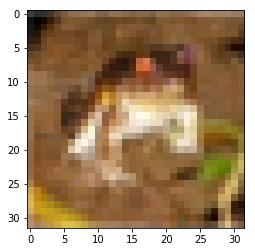

In [6]:
#display images
plt.imshow(data_1[0].reshape(3,32,32).transpose(1,2,0))

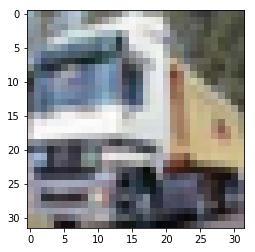

In [7]:
plt.imshow(data_1[1].reshape(3,32,32).transpose(1,2,0))

In [8]:
import tensorflow as tf

In [9]:
##CNN 
#helper functions
def init_weights(shape): #shape is of the form [filter height,filter width,no input channels,no output channel]
    w_init = tf.truncated_normal(shape=shape,stddev=0.1,dtype=tf.float32)
    b_init = tf.zeros(shape=shape[3],dtype=tf.float32)
    return tf.Variable(w_init),tf.Variable(b_init)

def conv2d(x,W): 
    #x --> input 
    #W --> filter 
    out = tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')
    return out

def conv_layer(x,shape):
    W,b = init_weights(shape)
    output = tf.nn.relu(conv2d(x,W)+b)
    return output

def pooling_layer(x):
    #x --> input
    #applies max pooling on the input using 2x2 window and stride of 2
    out = tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    return out

In [10]:
#DENSELY CONNECTED LAYER
def dense_layer(x,out_units):
    in_units = int(x.get_shape()[1])
    W = tf.Variable(tf.truncated_normal(shape=[in_units,out_units],stddev=0.1,dtype=tf.float32))
    b = tf.Variable(tf.zeros([out_units],dtype=tf.float32))
    out = tf.matmul(x,W) + b
    return out

In [11]:
###tensorflow modelling
 #create varibles and placeholders
 #create loss function and optimizer
 #create session,train the model,print outputs

In [12]:
tfX = tf.placeholder(tf.float32,shape=[None,32,32,3])
tfY = tf.placeholder(tf.float32,shape=[None,10])

In [13]:
#computational graph
#convolution layer 1
conv_1 = conv_layer(tfX,[4,4,3,32])
#max pooling layer 1
pool_1 = pooling_layer(conv_1)
#convolution layer 2
conv_2 = conv_layer(pool_1,[4,4,32,64])
#pooling layer 2
pool_2 = pooling_layer(conv_2)

In [14]:
#flatten the output of pooling layer
dense_input = tf.reshape(pool_2,[-1,8*8*64])
#densely connected layer with 1024 units
dense_1 = tf.nn.relu(dense_layer(dense_input,1024))

In [15]:
#add dropout to output of dense_1
keep_probs = tf.placeholder(tf.float32)
dropout_1 = tf.nn.dropout(dense_1,keep_prob=keep_probs)

In [16]:
#  #densely connectd layer with 256 units
# dense_2 = tf.nn.relu(dense_layer(dropout_1,1024))

In [17]:
# #add dropout to the ouput of dense_2
# dropout_2 = tf.nn.dropout(dense_2,keep_prob=keep_probs)

In [18]:
#add final output layer with 10 output units
y_hat = dense_layer(dropout_1,10)

In [19]:
#prediction function
predictions = tf.argmax(y_hat,1)

#error measure
matches = tf.equal(predictions,tf.argmax(tfY,1))
accuracy = tf.reduce_mean(tf.cast(matches,tf.float32))

In [20]:
#loss and optimizer functions
cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tfY,logits=y_hat)
)

optimizer = tf.train.AdamOptimizer(0.001)
train = optimizer.minimize(cost)

In [21]:
#helper functions to input data
from sklearn.utils import shuffle
def one_hot_converter(x):
    x = x.ravel()
    n = x.shape[0]
    p = len(np.unique(x))
    out_vec = np.zeros((n,p))
    out_vec[range(n),x] = 1.0
    return out_vec

def next_batch(batch_size,train_set,n_iter):
    X = all_data[train_set]['data'] 
    Y = one_hot_converter(np.array(all_data[train_set]['labels']))
    batch_X = X[(n_iter*batch_size):((n_iter*batch_size)+batch_size),:]
    batch_Y = Y[(n_iter*batch_size):((n_iter*batch_size)+batch_size),:]
    batch_X = batch_X.reshape(-1,3,32,32).transpose(0,2,3,1)/255.0
    return batch_X,batch_Y

def test_data():
    X = all_data[6]['data']
    Y = one_hot_converter(np.array(all_data[6]['labels']))
    X = X.reshape(-1,3,32,32).transpose(0,2,3,1)/255.0
    X,Y = shuffle(X,Y)
    return X[:2000,:],Y[:2000,:]

In [22]:
init = tf.global_variables_initializer()

In [23]:
batch_size = 100
n_epochs = 10
prob = 0.5
print_period = 10

In [24]:
losses = []
test_accs = []

n_iters = int(data_1.shape[0]/batch_size)
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for n_iter in range(n_iters):
            train_set = (epoch%5) + 1
            batch_X,batch_Y = next_batch(batch_size,train_set,n_iter)
            
            _,l = sess.run([train,cost],feed_dict={tfX:batch_X,tfY:batch_Y,keep_probs:prob})
            losses.append(l)
            
            if n_iter%print_period == 0:
                test_d,test_l = test_data()
                test_acc = sess.run(accuracy,feed_dict={tfX:test_d,tfY:test_l,keep_probs:1.0})
                test_accs.append(test_acc)
                print('Epoch %d,Iter : %d,train loss :%.4f,test acc : %.4f' %(epoch,n_iter,l,test_acc))

Epoch 0,Iter : 0,train loss :8.3175,test acc : 0.1170
Epoch 0,Iter : 10,train loss :2.4098,test acc : 0.1515
Epoch 0,Iter : 20,train loss :2.2870,test acc : 0.2645
Epoch 0,Iter : 30,train loss :2.0965,test acc : 0.2805
Epoch 0,Iter : 40,train loss :1.9332,test acc : 0.3565
Epoch 0,Iter : 50,train loss :1.9397,test acc : 0.3705
Epoch 0,Iter : 60,train loss :1.7269,test acc : 0.4020
Epoch 0,Iter : 70,train loss :1.7147,test acc : 0.3765
Epoch 0,Iter : 80,train loss :1.7774,test acc : 0.4030
Epoch 0,Iter : 90,train loss :1.7706,test acc : 0.4060
Epoch 1,Iter : 0,train loss :1.6363,test acc : 0.4190
Epoch 1,Iter : 10,train loss :1.6116,test acc : 0.4350
Epoch 1,Iter : 20,train loss :1.6513,test acc : 0.4585
Epoch 1,Iter : 30,train loss :1.6468,test acc : 0.4625
Epoch 1,Iter : 40,train loss :1.5622,test acc : 0.4460
Epoch 1,Iter : 50,train loss :1.7673,test acc : 0.4590
Epoch 1,Iter : 60,train loss :1.5354,test acc : 0.4775
Epoch 1,Iter : 70,train loss :1.4355,test acc : 0.4870
Epoch 1,Iter

In [25]:
# with tf.Session() as sess:
#     sess.run(init)
#     print('Variables initialized')
#     for i in range(10):
#         batch_X,batch_Y = next_batch(batch_size,1,i)
    
#         _,l = sess.run([train,cost],feed_dict={tfX:batch_X,tfY:batch_Y,keep_probs:prob})
#         print('%d,loss : %.4f' %(i,l))

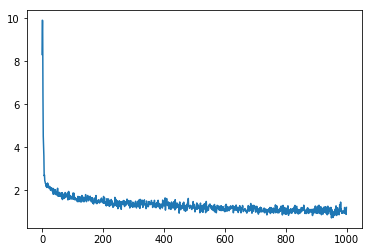

In [26]:
plt.plot(losses)

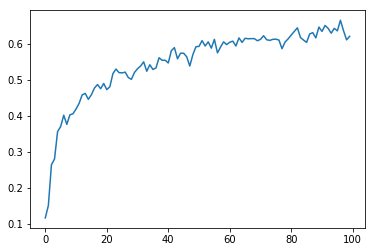

In [27]:
plt.plot(test_accs)